In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from pyspark.sql import SparkSession, DataFrame

In [6]:
sp = SparkSession.builder.appName("Ranking score checker").getOrCreate()

In [7]:
scores = sp.read.option("inferSchema", True).parquet("../data/Normalised/Final_scores/")
scores.show(1)

+------------+--------------+-------------+--------------+--------------+------+--------------------+
|merchant_abn|Customer_score|Revenue_score|Industry_score|Merchant_score| total|              sector|
+------------+--------------+-------------+--------------+--------------+------+--------------------+
| 38986645707|    0.47114496|   0.90117049|           1.0|    0.68376361|3.0561|Arts_Recreation_S...|
+------------+--------------+-------------+--------------+--------------+------+--------------------+
only showing top 1 row



In [5]:
scores.count()

4008

In [8]:
scores_pd = scores.toPandas()
scores_pd.head(3)

,merchant_abn,Customer_score,Revenue_score,Industry_score,Merchant_score,total,sector
0,38986645707,0.471145,0.901170,1.000000,0.683764,3.0561,Arts_Recreation_Services
1,78916025936,0.298007,0.920832,9.969806,0.432964,11.6216,Administrative_Support_Services
2,96946925998,0.209032,0.850268,1.000000,0.272484,2.3318,Arts_Recreation_Services


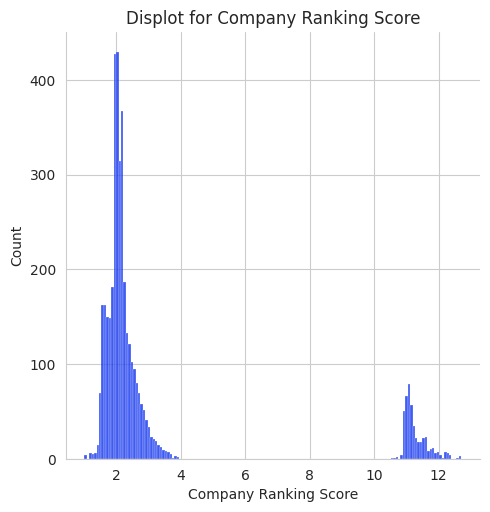

In [9]:
import matplotlib.pyplot as plt

sns.set_palette("winter")
sns.set_style("whitegrid")

sns.displot(scores_pd["total"])

plt.xlabel("Company Ranking Score")
plt.ylabel("Count")

plt.title("Displot for Company Ranking Score")
plt.show()

In [10]:
scores_pd.describe()

,merchant_abn,Customer_score,Revenue_score,Industry_score,Merchant_score,total
count,4.008000e+03,4007.000000,4.008000e+03,4008.000000,4.007000e+03,4007.000000
mean,5.443616e+10,0.156895,8.735234e-01,1.941737,2.377569e-01,3.210224
std,2.599297e+10,0.171906,1.344249e-01,2.917145,2.216336e-01,2.956916
min,1.002328e+10,0.000000,1.600000e-07,0.605595,4.000000e-08,1.024300
25%,3.160456e+10,0.014078,8.545154e-01,0.605595,6.041765e-02,1.944300
50%,5.429183e+10,0.104006,9.049717e-01,1.000000,1.870563e-01,2.136500
75%,7.662666e+10,0.245520,9.500401e-01,1.000000,3.405890e-01,2.544150
max,9.998791e+10,1.000000,1.000000e+00,9.969806,9.968026e-01,12.697700


## INSIGHTS FROM TOP 100

### Profit generated by top 100 compared to the next 200?

In [18]:
top100 = scores_pd.sort_values(by="total", ascending=False)["merchant_abn"][:100]

In [19]:
merchants = sp.read.option("inferSchema", True).option("header", True).csv("../data/tables/merchants_tbl_processed.csv")
merchants.show(1)

+-------------+------------+--------------------+--------------+--------+
|         name|merchant_abn|         Description|Earnings_Class|BNPL_Fee|
+-------------+------------+--------------------+--------------+--------+
|Felis Limited| 10023283211|furniture home fu...|             e|    0.18|
+-------------+------------+--------------------+--------------+--------+
only showing top 1 row



In [21]:
transactions = sp.read.option("inferSchema", True).parquet("../data/curated/transactions/")
transactions.show(1)

+-------+------------+------------+--------------+-----------+
|user_id|merchant_abn|dollar_value|order_datetime|   order_id|
+-------+------------+------------+--------------+-----------+
|  14935| 79417999332|      136.07|    2021-11-26|68719476736|
+-------+------------+------------+--------------+-----------+
only showing top 1 row



In [23]:
revenue = transactions.groupBy("merchant_abn").sum("dollar_value").withColumnRenamed("sum(dollar_value)", "revenue")
revenue.show(1)

+------------+-----------------+
|merchant_abn|          revenue|
+------------+-----------------+
| 83412691377|498536.9797888398|
+------------+-----------------+
only showing top 1 row



In [24]:
rev_merchant = revenue.join(merchants.drop("name", "Description"), on="merchant_abn")
rev_merchant.show(1)

+------------+-----------------+--------------+--------+
|merchant_abn|          revenue|Earnings_Class|BNPL_Fee|
+------------+-----------------+--------------+--------+
| 83412691377|498536.9797888398|             c|    2.94|
+------------+-----------------+--------------+--------+
only showing top 1 row



In [26]:
from pyspark.sql.types import FloatType

rev_merchant = rev_merchant.withColumn("profit", (col('revenue') * col("BNPL_Fee") / 100).cast(FloatType()))
rev_merchant.show(1)

+------------+-----------------+--------------+--------+---------+
|merchant_abn|          revenue|Earnings_Class|BNPL_Fee|   profit|
+------------+-----------------+--------------+--------+---------+
| 83412691377|498536.9797888398|             c|    2.94|14656.987|
+------------+-----------------+--------------+--------+---------+
only showing top 1 row



In [27]:
profit_table = rev_merchant.join(scores, on="merchant_abn")
profit_table.show(1)

22/10/10 02:11:39 ERROR Executor: Exception in task 0.0 in stage 30.0 (TID 60)
java.io.FileNotFoundException: 
File file:/home/jay/Classes/Apl-DS/generic-buy-now-pay-later-project-group-3/data/Normalised/Final_scores/part-00000-da190ec7-8008-48bc-83e3-d207e57ca2f5-c000.snappy.parquet does not exist

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	a

Py4JJavaError: An error occurred while calling o113.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 30.0 failed 1 times, most recent failure: Lost task 0.0 in stage 30.0 (TID 60) (172.28.113.244 executor driver): java.io.FileNotFoundException: 
File file:/home/jay/Classes/Apl-DS/generic-buy-now-pay-later-project-group-3/data/Normalised/Final_scores/part-00000-da190ec7-8008-48bc-83e3-d207e57ca2f5-c000.snappy.parquet does not exist

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:553)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.sql.execution.SparkPlan.executeCollectIterator(SparkPlan.scala:431)
	at org.apache.spark.sql.execution.exchange.BroadcastExchangeExec.$anonfun$relationFuture$1(BroadcastExchangeExec.scala:137)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$1(SQLExecution.scala:191)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.FileNotFoundException: 
File file:/home/jay/Classes/Apl-DS/generic-buy-now-pay-later-project-group-3/data/Normalised/Final_scores/part-00000-da190ec7-8008-48bc-83e3-d207e57ca2f5-c000.snappy.parquet does not exist

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:553)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	... 3 more
